In [163]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import gzip
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import community
%matplotlib inline

### Data loading part 

In [4]:
ti_network_file = '/home/hirak/Projects/CMSC828O/data/chilean_TI.txt'

In [5]:
df = pd.read_csv(ti_network_file,sep = '\t')

In [6]:
metadata_nodes = df[df.columns[:2].values]
metadata_nodes.columns = ['node_id', 'sp_name']

In [7]:
adj_df = df.loc[:,df.columns.isin(df.columns[2:])]

In [9]:
adj_mat = adj_df.values

In [10]:
G = nx.from_numpy_matrix(adj_mat)

In [12]:
G.number_of_nodes()

106

### Stochastic Block Model implementation

In [14]:
def random_partition(num_classes, G):
    labels = np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        labels[i] = int(np.random.choice(num_classes))
    return labels.astype(int)

In [71]:
random_partitions = {}
for Q in range(3, 21):
    random_partitions[Q] = random_partition(Q, G)

In [15]:
from sklearn.cluster import SpectralClustering

In [17]:
#sc = SpectralClustering(10, affinity='precomputed')

In [18]:
#sc.fit(adj_mat)

In [24]:
num_nodes = G.number_of_nodes()

#### VBEM Algorithm implementation

In [25]:
eps = 1e-1
crit = 1e-5

def boundary(mat, low = eps, high = 1-eps):
    mat[mat < low] = low
    mat[mat > high] = high
    return mat

In [179]:
from numpy.linalg import multi_dot

def entropy(mat):
    return (-(mat)*np.log(mat)).sum()


class SBM_model(object):
    def __init__(self, adj_mat, num_classes, labels):
        self.num_nodes, self.num_classes = adj_mat.shape[0], num_classes
        
        self.theta = np.zeros((self.num_classes,self.num_classes))
        self.alpha = np.zeros(self.num_classes)
        self.tau = np.zeros((self.num_nodes, self.num_classes))
        
        for i,j in enumerate(labels):
            self.tau[i,j] = 0.5
            for k in range(self.num_classes):
                if j != k:
                    self.tau[i,k] = 0.5 / (self.num_classes-1)

        #make tau a prob-dist
        #boundary
        self.eps_tol = eps / self.tau.shape[0]
        self.tau = boundary(self.tau, self.eps_tol, 1 - self.eps_tol)
        #normalize
        self.tau = self.tau/self.tau.sum(axis=1, keepdims=1)
            
        #make alpha a prob-dist
        self.alpha = self.tau.sum(0)/ num_nodes
        #boundary
        self.alpha = boundary(self.alpha)
        #normalize
        self.alpha = self.alpha / self.alpha.sum()
        
        #calc auxiliary metrices
        self.adj = adj_mat.copy()
        self.adjt = self.adj.T
        
        self.adjZD = self.adj.copy()
        np.fill_diagonal(self.adjZD, 0)
        self.adjZDt = self.adjZD.T
        
        self.one_minus_adj_ZD = 1 - self.adj 
        np.fill_diagonal(self.one_minus_adj_ZD, 0)
        self.one_minus_adj_ZDt = self.one_minus_adj_ZD.T
        
        self.adj_oneZD = np.full((self.num_nodes, self.num_nodes), 1.)
        np.fill_diagonal(self.adj_oneZD, 0)
        
        #calc theta
        self.theta = (
            multi_dot([self.tau.T, self.adjZD, self.tau]) /
            multi_dot([self.tau.T, self.adj_oneZD, self.tau])
        )
        
    def estep(self):
        ite = 0
        Z = self.tau.copy()
        while(True):
            lZ = np.tile(np.log(self.alpha), (self.num_nodes, 1))
            lZ += (
                multi_dot([self.adjZD, self.tau, np.log(self.theta).T]) +
                multi_dot([self.one_minus_adj_ZD, self.tau, np.log(1 - self.theta).T]) +
                multi_dot([self.adjZDt, self.tau, np.log(self.theta)]) +
                multi_dot([self.one_minus_adj_ZDt, self.tau, np.log(1 - self.theta)])
            )

            #follow the real SBM implementation
            lZ = lZ - np.tile(self.tau.max(1), (self.num_classes,1)).T
            lZ = np.exp(lZ)

            #normalize
            lZ = lZ / lZ.sum(axis=1, keepdims=1)

            #boundary
            lZ = boundary(lZ, self.eps_tol, 1-self.eps_tol)

            #normalize
            lZ = lZ / lZ.sum(axis=1, keepdims=1)
            step_size = np.max(abs(Z - lZ))
            #print(step_size)
            
            ite += 1
            if(step_size <= 1e-2):
                break
        
            Z = lZ.copy()
            
        self.tau = Z.copy()
        
    def mstep(self):
    
        self.alpha = self.tau.sum(0)/ num_nodes
        self.theta = (
            multi_dot([self.tau.T, self.adjZD, self.tau]) /
            multi_dot([self.tau.T, self.adj_oneZD, self.tau])
        )
        
    def likelihood(self):
        prior = (self.tau * np.log(self.alpha).T).sum()
        post = (
            (multi_dot([self.tau.T, self.adjZD, self.tau]) *
            (np.log(self.theta) - np.log(1 - self.theta))).sum() +
            (multi_dot([self.tau.T, self.adj_oneZD, self.tau]) *
             np.log(1 - self.theta)).sum()
            )
        return prior + post
    
    def entropy(self):
        return (-(self.tau)*np.log(self.tau)).sum()

In [180]:
def get_model(num_classes, sc=False):
    if not sc:
        random_labels = random_partitions[num_classes]
    else:
        scc = SpectralClustering(num_classes, affinity='precomputed', n_init=100)
        scc.fit(adj_mat)
        random_labels = scc.labels_
    sbm = SBM_model(adj_mat, num_classes, random_labels)

    J = sbm.entropy() + sbm.likelihood()
    old_J = 0
    while(True):
        # run e step
        sbm.estep()

        # store entropy
        E = sbm.entropy()

        #run m step
        num_iter = 10
        sbm.mstep()
        old_J = J

        J = E + sbm.likelihood()

        
        #print(sbm.tau[0])
        if(J - old_J <= 1e-6):
            break
    print('E:{}, J:{}, J\':{}'.format(E,J,old_J))
    return (sbm)

In [181]:
models_sc = {}
models = {}
for Q in range(3,21):
    models[Q] = get_model(Q)
    models_sc[Q] = get_model(Q, sc = True)

E:3.8152201864677022, J:-2518.821995709202, J':-2518.821995709202


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:3.810861811870496, J:-2518.821664506224, J':-2518.821664506224
E:3.746738280816748, J:-1955.0272133528983, J':-1955.0272133528983


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:2.884698257526842, J:-1943.6119655005289, J':-1943.6119655005289
E:4.032713145190886, J:-1771.1318760672762, J':-1771.1318760672762


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:4.091928815499843, J:-1788.1766175566877, J':-1788.1766175566877
E:4.577662223951588, J:-1657.5097149634894, J':-1657.5097149634894


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:4.794773289593178, J:-1677.715448262613, J':-1677.715448262613
E:5.4071722584509985, J:-1571.5859077206824, J':-1571.5859077206824


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:6.188319787407499, J:-1676.8535325714734, J':-1676.8535325714734
E:5.66575325882012, J:-1502.308050939592, J':-1502.308050939592


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:6.02495606668196, J:-1493.7225598456557, J':-1493.7225598456557
E:9.850216334335476, J:-1529.1022842724296, J':-1529.1022842724296


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:12.156905342007436, J:-1551.836295776726, J':-1551.836295776726
E:9.968778021210047, J:-1436.0494900869426, J':-1436.0494900869426


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:7.314422447214906, J:-1402.4181085866676, J':-1402.4181085866676
E:8.095114891197062, J:-1374.2699432700495, J':-1374.2699432700495


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:13.203685730849312, J:-1498.144045232479, J':-1498.144045232479
E:8.79238441964258, J:-1442.790369227721, J':-1442.790369227721


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:9.22471312668944, J:-1426.6258326602774, J':-1426.6258326602774
E:9.644205143220502, J:-1344.628298692282, J':-1344.628298692282


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:14.78798369154962, J:-1562.2754722303966, J':-1562.2754722303966
E:11.008060362046681, J:-1360.7310451943945, J':-1360.7310451943945


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:16.62998823733959, J:-1538.4174475596108, J':-1538.4174475596108
E:11.618292978464858, J:-1371.4794169820934, J':-1371.4794169820934


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:11.119900465328586, J:-1484.2324686844067, J':-1484.2324686844067
E:12.28969487036542, J:-1505.2549121043699, J':-1505.2549121043699


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:12.954798925607417, J:-1358.6683919098837, J':-1358.6683919098837
E:13.72096908150947, J:-1403.8731472728468, J':-1403.8731472728468


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:16.806230514227344, J:-1514.9509982875197, J':-1514.9509982875197
E:16.478200683266255, J:-1415.7003248125327, J':-1415.7003248125327


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:15.127325978509198, J:-1342.8750754591113, J':-1342.8750754591113
E:14.449058402923608, J:-1332.815722704846, J':-1332.815722704846


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:18.429148559546, J:-1514.9613410939241, J':-1514.9613410939241
E:15.865692806849525, J:-1369.9476319962375, J':-1369.9476319962375


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


E:16.256206282547826, J:-1396.8045368683815, J':-1396.8045368683815


In [182]:
len(models)

18

In [335]:
icl_vec = {}
icl_vec_sc = {}
for Q in range(3,21):
    val = (
        models[Q].entropy() + models[Q].likelihood()   -
        0.5 * (
            (0.5*(Q)*(Q+1) * np.log(num_nodes*(num_nodes-1)) -
             (Q-1) * np.log(num_nodes)
            )
        )
    )
    
    val2 = (
        models_sc[Q].entropy() + models_sc[Q].likelihood() -
        0.5 * (
            (0.5*(Q)*(Q+1) * np.log(num_nodes*(num_nodes-1)) -
             (Q-1) * np.log(num_nodes)
            )
        )
    )
    
    icl_vec[Q] = [models[Q].entropy() + models[Q].likelihood(), val]
    icl_vec_sc[Q] = [models_sc[Q].entropy() + models_sc[Q].likelihood(), val2]

In [336]:
df_Q = pd.DataFrame.from_dict(icl_vec, 
                       orient = 'index',
                       columns = ['likelihood', 'ICL']
                      )

df_sc = pd.DataFrame.from_dict(icl_vec_sc, 
                       orient = 'index',
                       columns = ['likelihood', 'ICL']
                      )

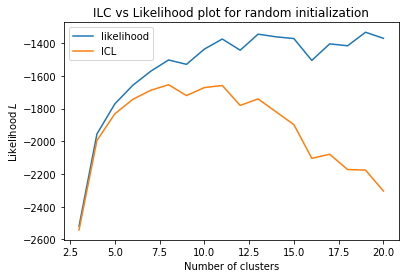

In [337]:
df_Q[['likelihood', 'ICL']].plot()
plt.ylabel('Likelihood $L$')
plt.xlabel('Number of clusters')
plt.title('ILC vs Likelihood plot for random initialization')
plt.show()

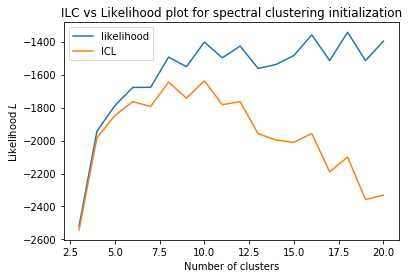

In [338]:
df_sc[['likelihood', 'ICL']].plot()
plt.ylabel('Likelihood $L$')
plt.xlabel('Number of clusters')
plt.title('ILC vs Likelihood plot for spectral clustering initialization')
plt.show()

In [339]:
opt_class_random = df_Q.loc[df_Q.ICL == df_Q.ICL.max()].index[0]

In [340]:
opt_class_spec = df_sc.loc[df_sc.ICL == df_sc.ICL.max()].index[0]

In [341]:
opt_class_spec

10

In [190]:
fig6_df = pd.read_csv(
    '../data/figureS6.csv'
)

In [230]:
cluster_id = {}
for i in range(G.number_of_nodes()):
    cluster_id[i] = np.argmax(models_sc[opt_class_spec].tau[i])

In [231]:
df_clust = pd.DataFrame.from_dict(
    cluster_id, 
    orient='index',
    columns = ['clust_id']
)

In [194]:
def get_entropy(model_num):
    return ((-(models_sc[model_num].tau) * np.log(models_sc[model_num].tau)))

In [195]:
def get_entropy_model(model_num):
    return ((-(models[model_num].tau) * np.log(models[model_num].tau)))

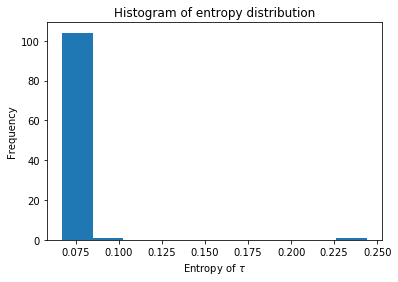

In [207]:
_ = plt.hist(get_entropy(opt_class_spec).sum(axis=1))
plt.ylabel('Frequency')
plt.xlabel('Entropy of $\\tau$')
plt.title('Histogram of entropy distribution')
plt.show()

### Non-probabilistic modularity methods (Louvain method)

In [244]:
clust_lv = community.best_partition(G, resolution = 0.71)

In [245]:
max(clust_lv.values())

9

In [246]:
df_lv = pd.DataFrame.from_dict(
    clust_lv, 
    orient='index',
    columns = ['lv']
)

In [247]:
joint_clust = df_clust.join(df_lv)

In [248]:
joint_clust = joint_clust.reset_index()

In [259]:
membership_mat_lv = np.zeros(((int(max(clust_lv.values())+1)), num_nodes))
membership_mat_sbm = np.zeros((opt_class_spec, num_nodes))

In [260]:
for g,l in  joint_clust.groupby('lv')['index'].apply(list).to_dict().items():
    membership_mat_lv[g,l] = 1

for g,l in  joint_clust.groupby('clust_id')['index'].apply(list).to_dict().items():
    membership_mat_sbm[g,l] = 1

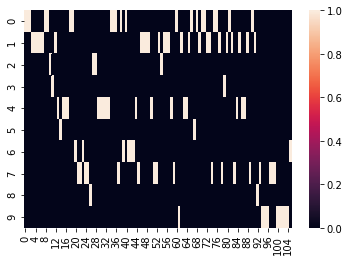

In [261]:
sns.heatmap(membership_mat_lv)

In [271]:
from scipy.spatial import distance
distance_mat = np.zeros((opt_class_spec, opt_class_spec))
for i in range(opt_class_spec):
    for j in range(opt_class_spec):
        if i <= j:
            distance_mat[i][j] = distance.jaccard(membership_mat_lv[i,], membership_mat_sbm[j,])
            distance_mat[j][i] = distance_mat[i][j]

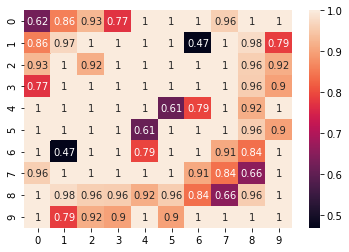

In [273]:
sns.heatmap(distance_mat, annot=True)

In [342]:
distance_mat.min(axis=1)

array([0.625     , 0.46875   , 0.91666667, 0.77272727, 0.61111111,
       0.61111111, 0.46875   , 0.65517241, 0.65517241, 0.78571429])

In [373]:
gt_dict = joint_clust.groupby('tro').node.apply(list).to_dict()

In [374]:
vbem_dict = joint_clust.groupby('clust_id').node.apply(list).to_dict()

In [376]:
def create_parity_matrix(cluster_dict):
    parity_mat = np.zeros((106,106))
    for clust in cluster_dict:
        node_list = cluster_dict[clust]
        for i,j in itertools.combinations(node_list, 2):
            parity_mat[i][j] = 1
            parity_mat[j][i] = 1
    return parity_mat

In [377]:
gt_mat = create_parity_matrix(gt_dict)

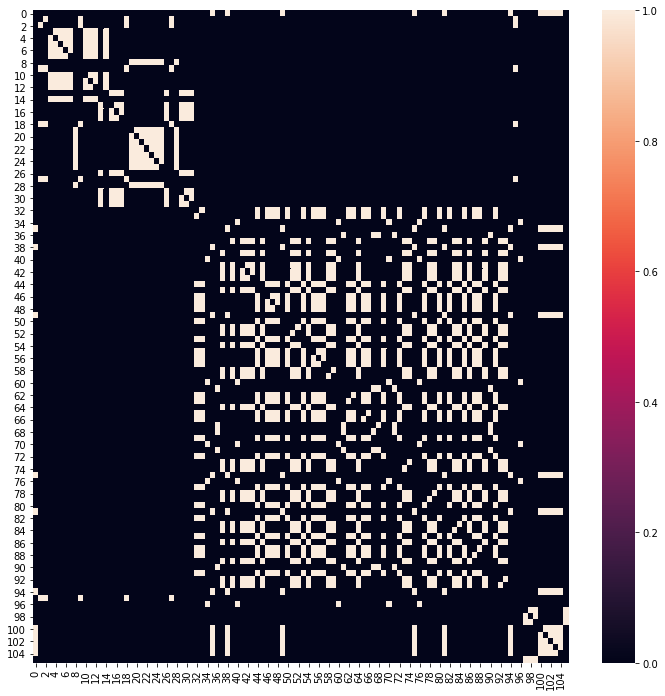

In [378]:
plt.figure(figsize=(12, 12))
sns.heatmap(gt_mat)

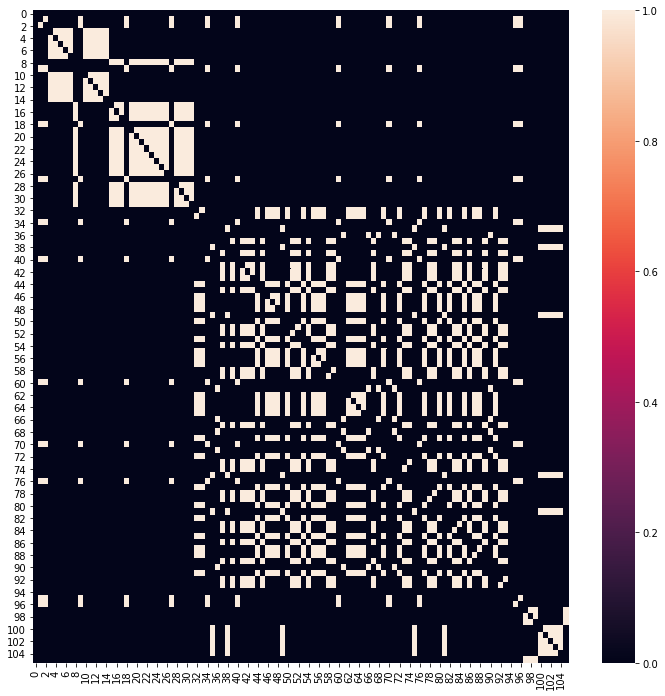

In [379]:
vbem_mat = create_parity_matrix(vbem_dict)
plt.figure(figsize=(12, 12))
sns.heatmap(vbem_mat)

In [278]:
from scipy.spatial import distance
distance_vec = []
for i in range(G.number_of_nodes()):
    distance_vec += [distance.jaccard(gt_mat[i,], vbem_mat[i,])]

(array([12., 11.,  9.,  6.,  0.,  8., 24.,  5., 22.,  9.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

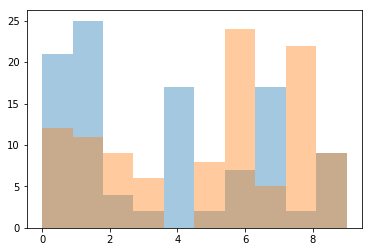

In [276]:
plt.hist(joint_clust.lv.values, alpha = 0.4)
plt.hist(joint_clust.clust_id.values, alpha = 0.4)

In [279]:
meta_data_df = pd.read_csv('../data/meta_data.csv', sep = '\t')

In [283]:
df[['Unnamed: 0','Unnamed: 1']]

,Unnamed: 0,Unnamed: 1
0,1,acanthina monodon
1,2,acanthocyclus gayi
2,3,acanthocyclus hassleri
3,4,acanthopleura echinata
4,5,chaetopleura peruviana
5,6,chiton cummingii
6,7,chiton granosus
7,8,chiton latus
8,9,lottia orbigny
9,10,concholepas concholepas


In [287]:
meta_data_df.index = np.arange(num_nodes).astype(int)

In [289]:
meta_data_df.join(joint_clust)

,Spec,Species names,BodyMass,sessile/mobile,Cluster,Shore Height 1 conservative,ShoreHt_C_Ordinal,ShoreHt_C_Breadth,Shore Height 2 restrictive,ShoreHt_R_Ordinal,ShortHt_R_Breadth,Phyllum,subphyllum,trophic,index,clust_id,lv
0,1,acanthina monodon,8.00000,M,4,"mid, low",1.5,2,low,1.0,1,Mollusca,Gastropoda,Predator,0,7,0
1,2,acanthocyclus gayi,6.01000,M,1,"mid, low",1.5,2,"mid, low",1.5,2,Arthropoda,Crustacae,Predator,1,0,0
2,3,acanthocyclus hassleri,6.65000,M,1,"mid, low",1.5,2,mid,2.0,1,Arthropoda,Crustacae,Predator,2,0,0
3,4,acanthopleura echinata,5.10000,M,7,low,1.0,1,low,1.0,1,Mollusca,Polyplacophora,Herbivore,3,9,1
4,5,chaetopleura peruviana,0.18000,M,7,low,1.0,1,low,1.0,1,Mollusca,Polyplacophora,Herbivore,4,9,1
5,6,chiton cummingsi,8.23000,M,7,low,1.0,1,low,1.0,1,Mollusca,Polyplacophora,Herbivore,5,9,1
6,7,chiton granosus,2.30000,M,7,"mid, low",1.5,2,mid,2.0,1,Mollusca,Polyplacophora,Herbivore,6,9,1
7,8,chiton latus,0.06000,M,7,"mid, low",1.5,2,mid,2.0,1,Mollusca,Polyplacophora,Herbivore,7,9,1
8,9,lottia orbignyi,0.02000,M,9,"high, mid",2.5,2,"high, mid",2.5,2,Mollusca,Gastropoda,Herbivore,8,2,0
9,10,concholepas concholepas,2.30000,M,1,"mid, low",1.5,2,low,1.0,1,Mollusca,Gastropoda,Predator,9,0,0


In [291]:
X = models_sc[opt_class_spec].tau

In [ ]:
for i in range(2,21):
    np.savetxt('../../828-O/assignment/assign3/vbem_models/' + 'file_' + str(i)+'.csv',
               , delimiter=',')
    with open('../../828-O/assignment/assign3/vbem_models/' + 'file_' + str(i)+)
    models_sc[]

In [295]:
from sklearn import preprocessing

In [296]:
le = preprocessing.LabelEncoder()

In [343]:
le.fit(meta_data_df.trophic.fillna('Unc').values)

LabelEncoder()

In [344]:
target = le.transform(meta_data_df.trophic.fillna('Unc').values)
#target = meta_data_df.BodyMass.values

In [345]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [346]:
reg = LinearRegression().fit(X, target)

In [347]:
#mean_squared_error(reg.predict(X),target)

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.4, random_state=0)

In [349]:
clf = LinearRegression().fit(X_train, y_train)

In [350]:
clf.score(X_test, y_test)      

0.7760287144145027

In [351]:
 from sklearn.model_selection import cross_val_score

In [352]:
scores = cross_val_score(LinearRegression(), X,target, cv=5)

In [353]:
scores

array([-1.60051100e+21,  9.17423940e-01,  3.51917486e-01,  8.29930651e-01,
       -2.92769074e+04])